<a href="https://colab.research.google.com/github/ywanglab/tflite-pi/blob/main/Model_Maker_Image_Classification_yw_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ywanglab/tflite-pi/blob/main/Model_Maker_Image_Classification_yw.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

The [TensorFlow Lite Model Maker library](https://www.tensorflow.org/lite/models/modify/model_maker) simplifies the process of adapting and converting a TensorFlow neural-network model to particular input data when deploying this model for on-device ML applications.

This notebook shows an end-to-end example that utilizes this Model Maker library to illustrate the adaption and conversion of a commonly-used image classification model to classify flowers on a mobile device.

## Prerequisites

To run this example, we first need to install several required packages, including Model Maker package that in GitHub [repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker).

In [ ]:
!sudo apt -y install libportaudio2  # Only needed for audio input, only install first time. 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 65.4 kB of archives.
After this operation, 223 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libportaudio2 amd64 19.6.0-1build1 [65.4 kB]
Fetched 65.4 kB in 1s (99.9 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 122349

In [ ]:

!pip install -q tflite-model-maker  # Only install it the first time. 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.3/577.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.3 MB/s eta

Import the required packages.

In [ ]:
import os

import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')

from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

import matplotlib.pyplot as plt

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're usin

RuntimeError: ignored

## Simple End-to-End Example

### Get the data

Let's get some images to play with this simple end-to-end example. Hundreds of images is a good start for Model Maker while more data could achieve better accuracy.

In [ ]:
# image_path = tf.keras.utils.get_file(
#       'flower_photos.tgz',
#       'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#       extract=True)
# image_path = os.path.join(os.path.dirname(image_path), 'flower_photos')

You could replace `image_path` with your own image folders. As for uploading data to colab, you could find the upload button in the left sidebar shown in the image below with the red rectangle. Just have a try to upload a zip file and unzip it. The root file path is the current path.

<img src="https://storage.googleapis.com/download.tensorflow.org/models/tflite/screenshots/model_maker_image_classification.png" alt="Upload File" width="800" hspace="100">

If you prefer not to upload your images to the cloud, you could try to run the library locally following the [guide](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) in GitHub.

In [ ]:
# Download the train set
!wget --no-check-certificate https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps.zip
    
# Download the test set
!wget --no-check-certificate https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps-test-set.zip


--2023-04-10 21:37:02--  https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 173.194.195.128, 173.194.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘rps.zip’

rps.zip             100%[===================>] 191.38M   179MB/s    in 1.1s    

2023-04-10 21:37:03 (179 MB/s) - ‘rps.zip’ saved [200682221/200682221]

--2023-04-10 21:37:03--  https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 173.194.195.128, 173.194.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘rps-

In [13]:
#!wget https://drive.google.com/file/d/1E5E6DRkoKIIi67lgzLz6CFbOSg1R_CA0/view?usp=sharing
!gdown 1E5E6DRkoKIIi67lgzLz6CFbOSg1R_CA0

Downloading...
From: https://drive.google.com/uc?id=1E5E6DRkoKIIi67lgzLz6CFbOSg1R_CA0
To: /content/moneybills.zip
100% 2.74G/2.74G [00:38<00:00, 71.7MB/s]


In [ ]:
import zipfile

# Extract the archive
local_zip = './rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/rps-train')
zip_ref.close()

local_zip = './rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/rps-test')
zip_ref.close()

In [ ]:
image_path = '/content/tmp/rps-train/rps/'  # this is the training data path. Replace it with the path of your data folder

### Run the example
The example just consists of 4 lines of code as shown below, each of which representing one step of the overall process.


Step 1.   Load input data specific to an on-device ML app. Split it into training data and testing data.

In [ ]:
data = DataLoader.from_folder(image_path)
train_data, val_data = data.split(0.9)
# train_data = DataLoader.from_folder(image_path)
test_data = DataLoader.from_folder('/content/tmp/rps-test/rps-test-set') 

In [ ]:
# train_data, rest_data = data.split(0.8)
# validation_data, test_data = rest_data.split(0.5)

Show 25 data images

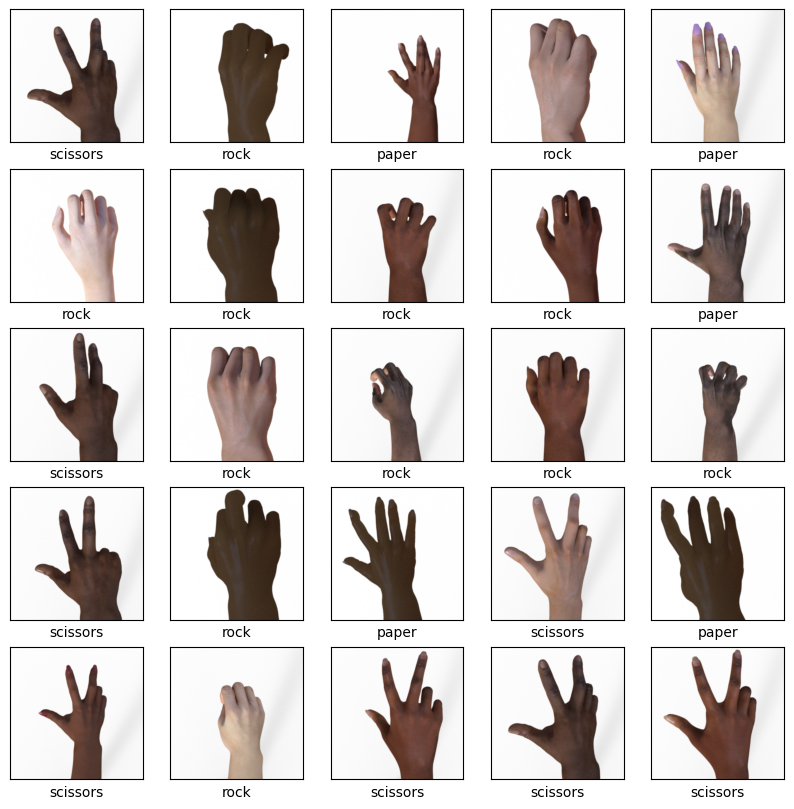

In [ ]:
data=train_data
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

Step 2. Customize the TensorFlow model.

### Change to the model that's supported in this library.

This library supports  EfficientNet-Lite models, MobileNetV2, ResNet50 by now. [EfficientNet-Lite](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet/lite) are a family of image classification models that could achieve state-of-art accuracy and suitable for Edge devices. The default model is EfficientNet-Lite0.

We could switch model to MobileNetV2 by just setting parameter `model_spec` to the MobileNetV2 model specification in `create` method.

To specify the model_spec for different models, consult https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/model_spec. 

In [ ]:
inception_v3_spec = image_classifier.ModelSpec(
    uri='https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1')
inception_v3_spec.input_image_shape = [299, 299]

In [ ]:
#model = image_classifier.create(train_data, model_spec=model_spec.get('mobilenet_v2'), validation_data=val_data)
# model_spec default is 'efficientnet_lite0'

In [ ]:
model = image_classifier.create(train_data,validation_data=val_data, model_spec=model_spec.get('efficientnet_lite0'), epochs=5)   # deault epochs=5. 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 3,416,867
Trainable params: 3,843
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/5
70/70 [==============================] - 33s 316ms/step - loss: 0.5341 - accuracy: 0.8879 - val_loss: 0.3584 - val_accuracy: 1.0000
Epoch 2/5
70/70 [==============================] - 20s 292ms/step - loss: 0.3617 - accuracy: 

Step 3. Evaluate the model.

In [ ]:
loss, accuracy = model.evaluate(test_data)

12/12 [==============================] - 4s 303ms/step - loss: 0.4919 - accuracy: 0.9194


Step 4.  Export to TensorFlow Lite model.

Here, we export TensorFlow Lite model with [metadata](https://www.tensorflow.org/lite/models/convert/metadata) which provides a standard for model descriptions. The label file is embedded in metadata. The default post-training quantization technique is full integer quantization for the image classification task.

You could download it in the left sidebar same as the uploading part for your own use.

In [ ]:
# model.export(export_dir='.')
# specifiy the export file name) 
model.export(export_dir='.', tflite_filename='rps.tflite', \
             label_filename='rps_labels.txt', \
                export_format=[ExportFormat.LABEL, ExportFormat.TFLITE])

/usr/local/lib/python3.9/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
# model.evaluate_tflite('model.tflite', test_data)
model_name = 'rps.tflite'
model.evaluate_tflite(model_name, test_data) #take a little bit long time ~ 10 min

{'accuracy': 1.0}

After these simple 4 steps, we could further use TensorFlow Lite model file in on-device applications like in [image classification](https://github.com/tensorflow/examples/tree/master/lite/examples/image_classification) reference app.

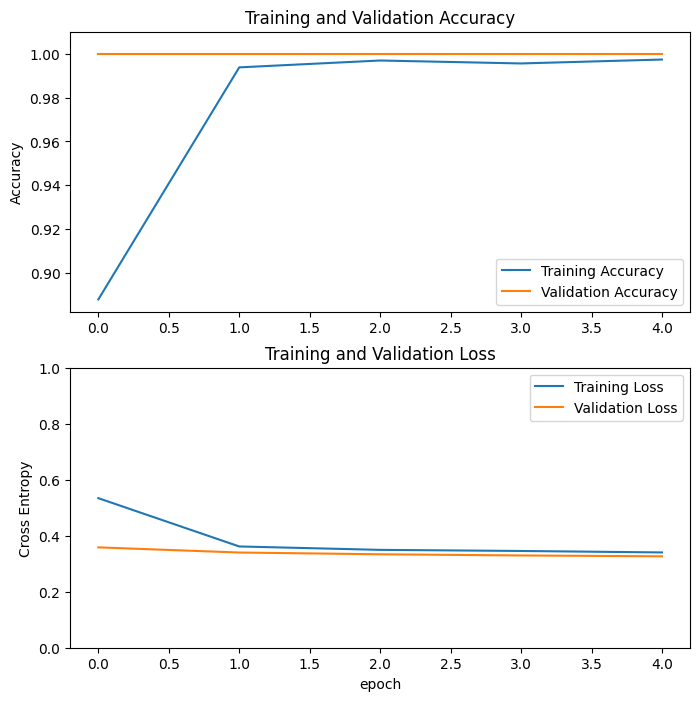

In [ ]:
hist=model.history

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.01])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

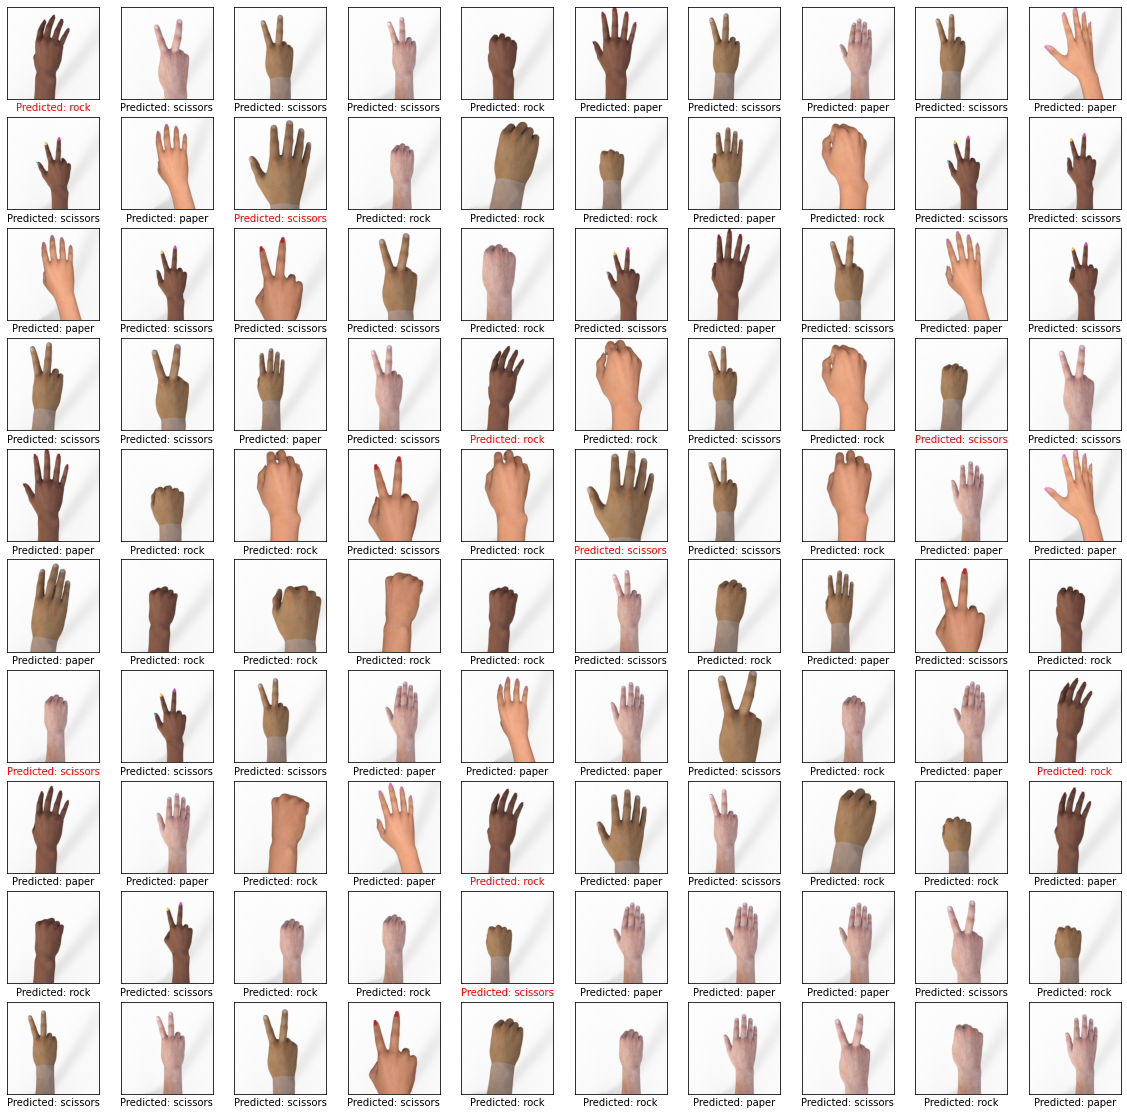

In [ ]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(20, 20))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(100)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

## Detailed Process

Currently, we support several models such as  EfficientNet-Lite* models, MobileNetV2, ResNet50 as pre-trained models for image classification. But it is very flexible to add new pre-trained models to this library with just a few lines of code.


The following walks through this end-to-end example step by step to show more detail.

### Step 1: Load Input Data Specific to an On-device ML App

The flower dataset contains 3670 images belonging to 5 classes. Download the archive version of the dataset and untar it.

The dataset has the following directory structure:

<pre>
<b>flower_photos</b>
|__ <b>daisy</b>
    |______ 100080576_f52e8ee070_n.jpg
    |______ 14167534527_781ceb1b7a_n.jpg
    |______ ...
|__ <b>dandelion</b>
    |______ 10043234166_e6dd915111_n.jpg
    |______ 1426682852_e62169221f_m.jpg
    |______ ...
|__ <b>roses</b>
    |______ 102501987_3cdb8e5394_n.jpg
    |______ 14982802401_a3dfb22afb.jpg
    |______ ...
|__ <b>sunflowers</b>
    |______ 12471791574_bb1be83df4.jpg
    |______ 15122112402_cafa41934f.jpg
    |______ ...
|__ <b>tulips</b>
    |______ 13976522214_ccec508fe7.jpg
    |______ 14487943607_651e8062a1_m.jpg
    |______ ...
</pre>

In [ ]:
# image_path = tf.keras.utils.get_file(
#       'flower_photos.tgz',
#       'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#       extract=True)
# image_path = os.path.join(os.path.dirname(image_path), 'flower_photos')

Use `DataLoader` class to load data.

As for `from_folder()` method, it could load data from the folder. It assumes that the image data of the same class are in the same subdirectory and the subfolder name is the class name. Currently, JPEG-encoded images and PNG-encoded images are supported.

In [ ]:
data = DataLoader.from_folder(image_path)

Split it to training data (80%), validation data (10%, optional) and testing data (10%).

In [ ]:
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

Show 25 image examples with labels.

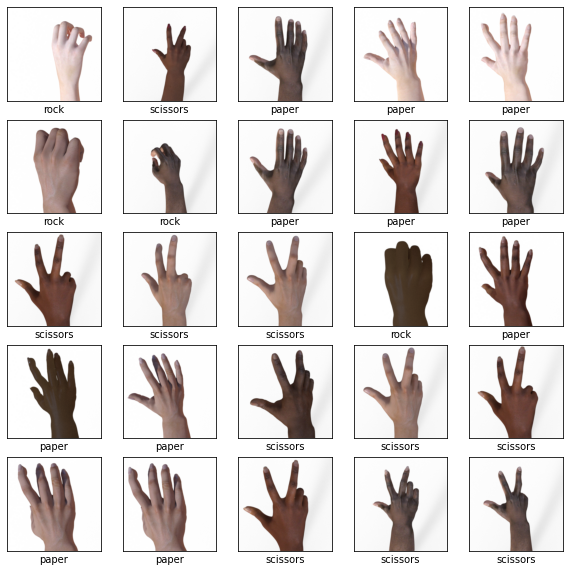

In [ ]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

### Step 2: Customize the TensorFlow Model

Create a custom image classifier model based on the loaded data. The default model is EfficientNet-Lite0.


In [ ]:
model = image_classifier.create(train_data, validation_data=validation_data,epochs=5)   # deault epochs=5.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2_4 (Hub  (None, 1280)             3413024   
 KerasLayerV1V2)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 3,416,867
Trainable params: 3,843
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/5
63/63 [==============================] - 21s 294ms/step - loss: 0.5544 - accuracy: 0.8760 - val_loss: 0.3643 - val_accuracy: 0.9960
Epoch 2/5
63/63 [==============================] - 18s 286ms/step - loss: 0.3678 - accuracy

Have a look at the detailed model structure.

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2_4 (Hub  (None, 1280)             3413024   
 KerasLayerV1V2)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 3,416,867
Trainable params: 3,843
Non-trainable params: 3,413,024
_________________________________________________________________


### Step 3: Evaluate the Customized Model

Evaluate the result of the model, get the loss and accuracy of the model.

In [ ]:
loss, accuracy = model.evaluate(test_data)

8/8 [==============================] - 8s 229ms/step - loss: 0.3262 - accuracy: 1.0000


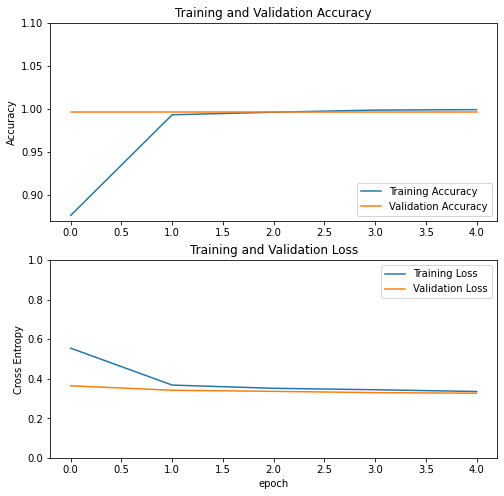

In [ ]:
hist=model.history

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

We could plot the predicted results in 100 test images. Predicted labels with red color are the wrong predicted results while others are correct.

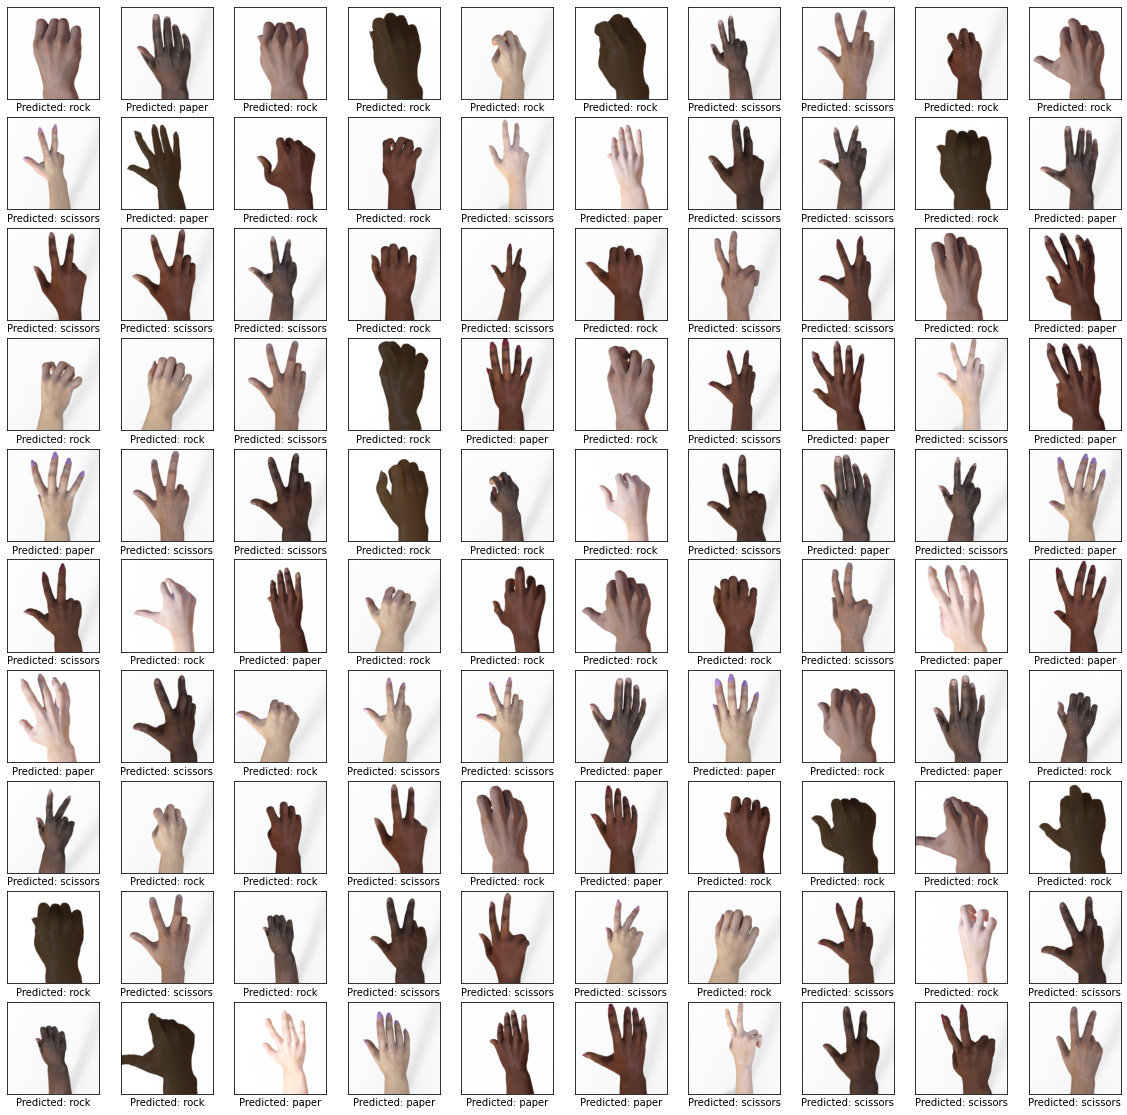

In [ ]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(20, 20))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(100)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

If the accuracy doesn't meet the app requirement, one could refer to [Advanced Usage](#scrollTo=zNDBP2qA54aK) to explore alternatives such as changing to a larger model, adjusting re-training parameters etc.

### Step 4: Export to TensorFlow Lite Model

Convert the trained model to TensorFlow Lite model format with [metadata](https://www.tensorflow.org/lite/models/convert/metadata) so that you can later use in an on-device ML application. The label file and the vocab file are embedded in metadata. The default TFLite filename is `model.tflite`.

In many on-device ML application, the model size is an important factor. Therefore, it is recommended that you apply quantize the model to make it smaller and potentially run faster.
The default post-training quantization technique is full integer quantization for the image classification task.

In [ ]:
# model.export(export_dir='.')
model.export(export_dir='.',tflite_filename='rps.tflite', label_filename='rps_labels.txt', export_format=[ExportFormat.LABEL, ExportFormat.TFLITE])


/usr/local/lib/python3.9/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


See the image classification [examples guide](https://www.tensorflow.org/lite/examples/image_classification/overview) for more details about how to integrate the TensorFlow Lite model into mobile apps.

This model can be integrated into an Android or an iOS app using the [ImageClassifier API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/image_classifier) of the [TensorFlow Lite Task Library](https://www.tensorflow.org/lite/inference_with_metadata/task_library/overview).

The allowed export formats can be one or a list of the following:

*   `ExportFormat.TFLITE`
*   `ExportFormat.LABEL`
*   `ExportFormat.SAVED_MODEL`

By default, it just exports TensorFlow Lite model with metadata. You can also selectively export different files. For instance, exporting only the label file as follows:

In [ ]:
# model.export(export_dir='.', export_format=ExportFormat.LABEL)
model.export(export_dir='.', label_filename='rps_labels.txt', export_format=ExportFormat.LABEL)

You can also evaluate the tflite model with the `evaluate_tflite` method.

In [ ]:
# model.evaluate_tflite('model.tflite', test_data)
model_name = 'rps.tflite'
model.evaluate_tflite(model_name, test_data) #take a little bit long time ~ 10 min

{'accuracy': 1.0}

## Advanced Usage

The `create` function is the critical part of this library. It uses transfer learning with a pretrained model similar to the [tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning).

The `create` function contains the following steps:

1.   Split the data into training, validation, testing data according to parameter `validation_ratio` and `test_ratio`. The default value of `validation_ratio` and `test_ratio` are `0.1` and `0.1`.
2.   Download a [Image Feature Vector](https://www.tensorflow.org/hub/common_signatures/images#image_feature_vector) as the base model from TensorFlow Hub. The default pre-trained model is  EfficientNet-Lite0.
3.   Add a classifier head with a Dropout Layer with `dropout_rate` between head layer and pre-trained model. The default `dropout_rate` is the default `dropout_rate` value from [make_image_classifier_lib](https://github.com/tensorflow/hub/blob/master/tensorflow_hub/tools/make_image_classifier/make_image_classifier_lib.py#L55) by TensorFlow Hub.
4.   Preprocess the raw input data. Currently, preprocessing steps including normalizing the value of each image pixel to model input scale and resizing it to model input size.   EfficientNet-Lite0 have the input scale `[0, 1]` and the input image size `[224, 224, 3]`.
5.   Feed the data into the classifier model. By default, the training parameters such as training epochs, batch size, learning rate, momentum are the default values from [make_image_classifier_lib](https://github.com/tensorflow/hub/blob/master/tensorflow_hub/tools/make_image_classifier/make_image_classifier_lib.py#L55) by TensorFlow Hub. Only the classifier head is trained.


In this section, we describe several advanced topics, including switching to a different image classification model, changing the training hyperparameters etc.


## Customize Post-training quantization on the TensorFLow Lite model


[Post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) is a conversion technique that can reduce model size and inference latency, while also improving CPU and hardware accelerator inference speed, with a little degradation in model accuracy. Thus, it's widely used to optimize the model.


Model Maker library applies a default post-training quantization techique when exporting the model. If you want to customize post-training quantization, Model Maker supports multiple post-training quantization options using [QuantizationConfig](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/config/QuantizationConfig) as well. Let's take float16 quantization as an instance. First, define the quantization config.

In [ ]:
config = QuantizationConfig.for_float16()

Then we export the TensorFlow Lite model with such configuration.

In [ ]:
model.export(export_dir='.', tflite_filename='rps_fp16.tflite', quantization_config=config)

In Colab, you can download the model named `model_fp16.tflite` from the left sidebar, same as the uploading part mentioned above.

## Change the model


### Change to the model that's supported in this library.

This library supports  EfficientNet-Lite models, MobileNetV2, ResNet50 by now. [EfficientNet-Lite](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet/lite) are a family of image classification models that could achieve state-of-art accuracy and suitable for Edge devices. The default model is EfficientNet-Lite0.

We could switch model to MobileNetV2 by just setting parameter `model_spec` to the MobileNetV2 model specification in `create` method.

To specify the model_spec for different models, consult https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/model_spec. 

In [ ]:
model = image_classifier.create(train_data, model_spec=model_spec.get('mobilenet_v2'), validation_data=validation_data)
# model_spec default is 'efficientnet_lite0'

Evaluate the newly retrained MobileNetV2 model to see the accuracy and loss in testing data.

In [ ]:
loss, accuracy = model.evaluate(test_data)

8/8 [==============================] - 8s 227ms/step - loss: 0.3129 - accuracy: 1.0000


### Change to the model in TensorFlow Hub

Moreover, we could also switch to other new models that inputs an image and outputs a feature vector with TensorFlow Hub format.

As [Inception V3](https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1) model as an example, we could define `inception_v3_spec` which is an object of [image_classifier.ModelSpec](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/image_classifier/ModelSpec) and contains the specification of the Inception V3 model.

We need to specify the model name `name`, the url of the TensorFlow Hub model `uri`. Meanwhile, the default value of `input_image_shape` is `[224, 224]`. We need to change it to `[299, 299]` for Inception V3 model.

In [ ]:
inception_v3_spec = image_classifier.ModelSpec(
    uri='https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1')
inception_v3_spec.input_image_shape = [299, 299]

Then, by setting parameter `model_spec` to `inception_v3_spec` in `create` method, we could retrain the Inception V3 model.

The remaining steps are exactly same and we could get a customized InceptionV3 TensorFlow Lite model in the end.

### Change your own custom model

If we'd like to use the custom model that's not in TensorFlow Hub, we should create and export [ModelSpec](https://www.tensorflow.org/hub/api_docs/python/hub/ModuleSpec) in TensorFlow Hub.

Then start to define `ModelSpec` object like the process above.

## Change the training hyperparameters
We could also change the training hyperparameters like `epochs`, `dropout_rate` and `batch_size` that could affect the model accuracy. The model parameters you can adjust are:


*   `epochs`: more epochs could achieve better accuracy until it converges but training for too many epochs may lead to overfitting.
*   `dropout_rate`: The rate for dropout, avoid overfitting. None by default.
*   `batch_size`: number of samples to use in one training step.  None by default.
*   `validation_data`: Validation data. If None, skips validation process. None by default.
*   `train_whole_model`: If true, the Hub module is trained together with the classification layer on top. Otherwise, only train the top classification layer. None by default.
*   `learning_rate`: Base learning rate. None by default.
*   `momentum`: a Python float forwarded to the optimizer. Only used when
      `use_hub_library` is True. None by default.
*   `shuffle`: Boolean, whether the data should be shuffled. False by default.
*   `use_augmentation`: Boolean, use data augmentation for preprocessing. False by default.
*   `use_hub_library`: Boolean, use `make_image_classifier_lib` from tensorflow hub to retrain the model. This training pipeline could achieve better performance for complicated dataset with many categories. True by default. 
*   `warmup_steps`: Number of warmup steps for warmup schedule on learning rate. If None, the default warmup_steps is used which is the total training steps in two epochs. Only used when `use_hub_library` is False. None by default.
*   `model_dir`: Optional, the location of the model checkpoint files. Only used when `use_hub_library` is False. None by default.

Parameters which are None by default like `epochs` will get the concrete default parameters in [make_image_classifier_lib](https://github.com/tensorflow/hub/blob/02ab9b7d3455e99e97abecf43c5d598a5528e20c/tensorflow_hub/tools/make_image_classifier/make_image_classifier_lib.py#L54) from TensorFlow Hub library or  [train_image_classifier_lib](https://github.com/tensorflow/examples/blob/f0260433d133fd3cea4a920d1e53ecda07163aee/tensorflow_examples/lite/model_maker/core/task/train_image_classifier_lib.py#L61).

For example, we could train with more epochs.


In [ ]:
model = image_classifier.create(train_data, validation_data=validation_data, epochs=10)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2_6 (Hub  (None, 1280)             3413024   
 KerasLayerV1V2)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 3,416,867
Trainable params: 3,843
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/10
63/63 [==============================] - 19s 271ms/step - loss: 0.5629 - accuracy: 0.8760 - val_loss: 0.3607 - val_accuracy: 0.9960
Epoch 2/10
63/63 [==============================] - 16s 258ms/step - loss: 0.3685 - accura

Evaluate the newly retrained model with 10 training epochs.

In [ ]:
loss, accuracy = model.evaluate(test_data)

8/8 [==============================] - 5s 134ms/step - loss: 0.3180 - accuracy: 1.0000


# Read more

You can read our [image classification](https://www.tensorflow.org/lite/examples/image_classification/overview) example to learn technical details. For more information, please refer to:

*   TensorFlow Lite Model Maker [guide](https://www.tensorflow.org/lite/models/modify/model_maker) and [API reference](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker).
*   Task Library: [ImageClassifier](https://www.tensorflow.org/lite/inference_with_metadata/task_library/image_classifier) for deployment.
*   The end-to-end reference apps: [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/image_classification/android), [iOS](https://github.com/tensorflow/examples/tree/master/lite/examples/image_classification/ios), and [Raspberry PI](https://github.com/tensorflow/examples/tree/master/lite/examples/image_classification/raspberry_pi).

